# NASA Earthdata Worldview

https://worldview.earthdata.nasa.gov/?p=geographic&l=SMAP_L4_Emult_Average&t=2018-08-01-T00%3A00%3A00Z&z=3&v=-180,-90,180,90

In [47]:
import numpy as np

In [207]:
from datetime import datetime, timedelta

In [208]:
start_date = '2018-01-01'
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = '2018-12-31'
end_date = datetime.strptime(end_date, '%Y-%m-%d')
delta = timedelta(weeks=+1)

In [209]:
extent = (-60, -170, 80, 180)
width = 1000
height = 400

In [210]:
relation = float(extent[2] - extent[0]) / (extent[3] - extent[1])
height = int(width * relation)
height

400

In [211]:
layer = 'SMAP_L4_Emult_Average'

In [212]:
nasa_url = "https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot"
nasa_url += "&TIME=%s" % start_date.strftime('%Y-%m-%d')
nasa_url += "&BBOX=%s" % ','.join([str(e) for e in extent])
nasa_url += "&CRS=EPSG:4326"
nasa_url += "&LAYERS=%s" % layer
nasa_url += "&FORMAT=image/png"
nasa_url += "&WIDTH={0:d}&HEIGHT={1:d}".format(width, height)

In [213]:
import requests
r = requests.get(nasa_url, allow_redirects=True)

In [214]:
img_binary = r.content

In [215]:
img_binary

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x01\x90\x08\x06\x00\x00\x00=MJa\x00\x00 \x00IDATx\x9c\xec\xbd\x7f\x84]k\x9b\xe7\x9d\x93d\xc8\x1fabd\xc8\x1fa\x8e\x91&/\xa1\xa3\xc5\xc8\x10&F\xb44\xa1C\x1f#M\xe8\xf0\xc4+M\xfe\x08}\xb43d\x08Oi\xd5\x9c\x90\xd2G\x1cq\xda>\xe4h\xa5UsJ\x1f\xe9GyZ\x1d\xea\xa1K\xcb\xcbS<1\xadL\x97\x1e\x99\xd7\x94Q\xc3\x1b\x9e\x98\x11#\xd7[\xdf{_\x9fu_\xeb\xce\xda\xbb\xf6\xae\xda\xbb\xf6\xae\xca\xba\xb8\xec\xbd\xd7\x8f{\xdd\xeb\xdek\xdd\xd7\xf5\xbd~\xddG\x8e\xb4\xd4RK#\xa0\x19\xdb;\x8f\xaa\x9d\xbd\xf6a\x1c\xf7\xd6\xab\xed\x96Z\x12\xb5\xcf\xcc\xc1\xa4\xed\xff\xe8\x13k\xff\xa7\x96Z\x9aJj\xe7\xd1\x96Zj\xa9\xa5\x96\x0e\x1c\xbd\x1a\xb1\xe0\x9a4\xb8\x1e\x07/\xec\xc2\xb8P\x8e\xc5^\xc7\xad\xa5\x8f\x83\xda\xff}zH\xa0{\x10\xe0\r@\xe7\xff\xdah\xff\xb7\x96Z\x9a\x1aj\xe7\xd2\x96Zj\xa9\xa5\x96\x0e\x04IX=\xdb\xe6\xa5m~\xb1\xcd\x8b\x01P.\xfa\xf6\xe7\xdb\xbc:\xa0P{\xba\xc3q\xbb\x01\x9e\xfb\x01\xbcwC{mg?\xfb\xdaRK-\rEW\x05\xb4;\xdd\xf7\xed\x98\xbe\xefd\xc0\xdc\xc9H\x

In [216]:
len(img_binary)

151224

In [217]:
from PIL import Image

In [218]:
with open('temp.png', 'wb') as f:
    f.write(r.content)

In [219]:
im_frame = Image.open('temp.png')

In [220]:
data = np.array(im_frame.getdata()).reshape(height, -1, 4)

In [221]:
data.shape

(400, 1000, 4)

In [222]:
%matplotlib inline
from matplotlib import pyplot as plt

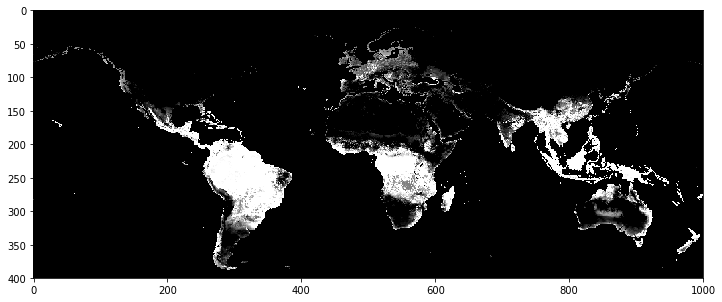

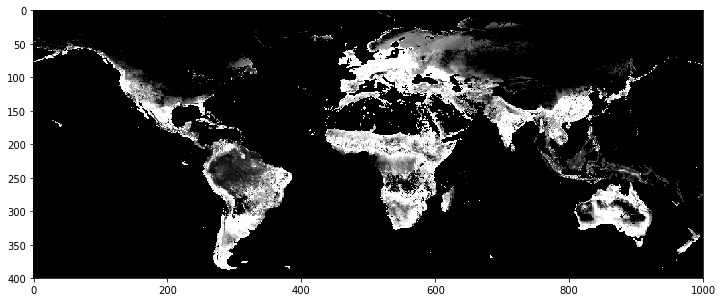

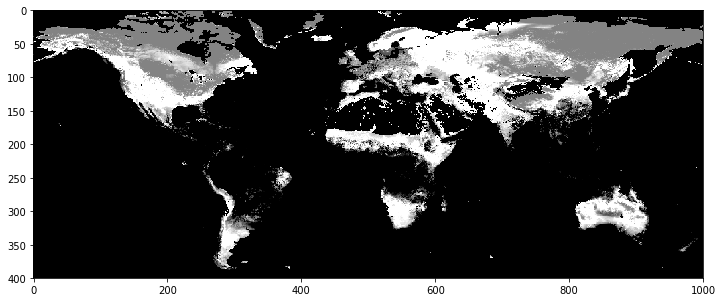

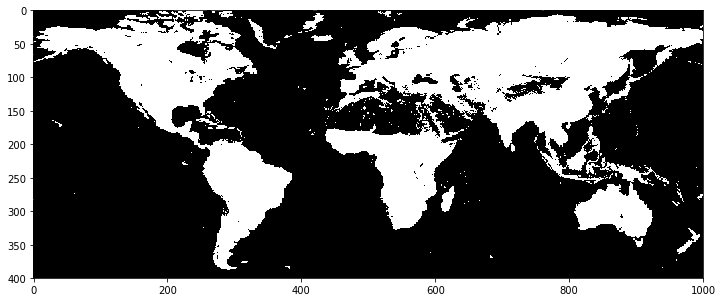

In [223]:
for i in range(4):
    plt.figure(figsize=(12, 10))
    plt.imshow(data[..., i], cmap='gray')

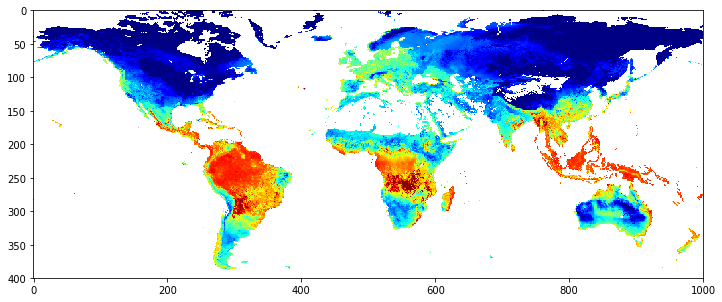

In [225]:
plt.figure(figsize=(12, 10))
plt.imshow(data, cmap='gray')

In [230]:
np.max(np.where(np.sum(data, axis=(-2, -1)))) <= height*0.15

False